# Test Fly Abdomens 2D projection

This notebook is used to test separately each step used in the 2D projection of the surface of a pre registered fly abdomen, and to generate some illustrative images.

In [6]:
# import packages 
from skimage import io, transform
from skimage import morphology
from skimage.filters import gaussian
from skimage.measure import label, regionprops, block_reduce
from scipy import stats, ndimage
from scipy.signal import find_peaks
from scipy.ndimage import convolve1d
from scipy.interpolate import make_interp_spline
import numpy as np
import open3d as o3d
import copy
import time
import os
import matplotlib.pyplot as plt
import sys

%matplotlib notebook

gfp_filename = "../../data/03_registered/Registered_C1-D3_en_pnr_male_02_20221025.tif"
dsred_filename = "../../data/03_registered/Registered_C2-D3_en_pnr_male_02_20221025.tif"

abdomen_mask_file = "../../data/References_and_masks/Reference_abdomen_mask_iso_thick.tif"
abdomen_shape_reference_file = "../../data/References_and_masks/Reference_abdomen_mask_iso.tif"

image_gfp = io.imread(gfp_filename)
image_dsred = io.imread(dsred_filename)
image_mask = io.imread(abdomen_mask_file)
ref_shape = io.imread(abdomen_shape_reference_file)

image_gfp = image_gfp*image_mask
image_dsred = image_dsred*image_mask

<IPython.core.display.Javascript object>


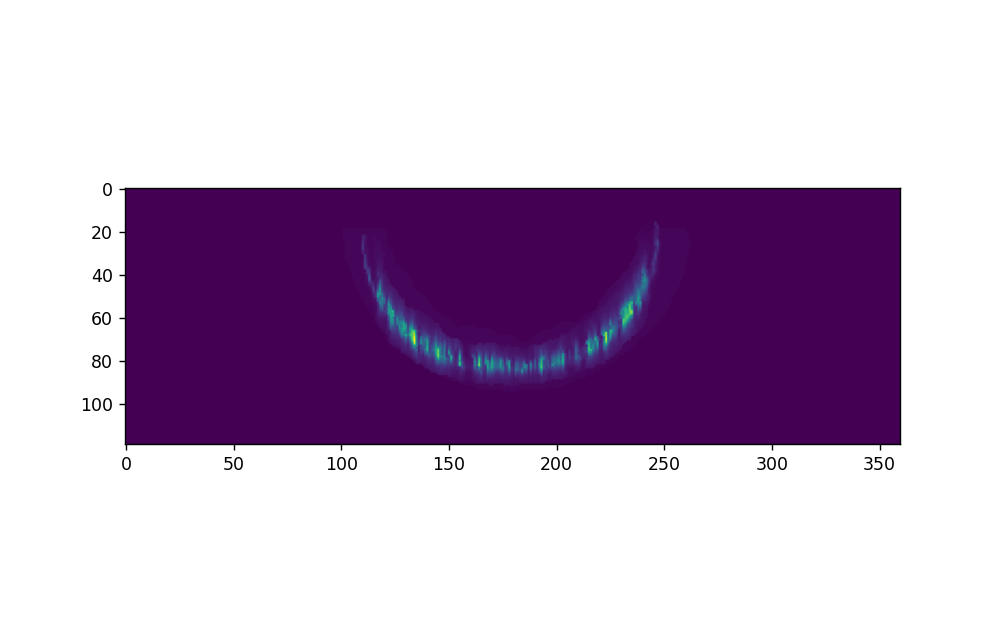

In [7]:
layer = 114
img_slice = (image_dsred)[:,:,layer]
ref_shape_slice = (ref_shape)[:,:,layer]
ref_mask_slice = ndimage.distance_transform_cdt(img_slice>0)

fig, ax = plt.subplots(figsize=(8, 5))
ax.imshow(img_slice+1000*ref_shape_slice)

### Test spline fitting of image slice

<IPython.core.display.Javascript object>


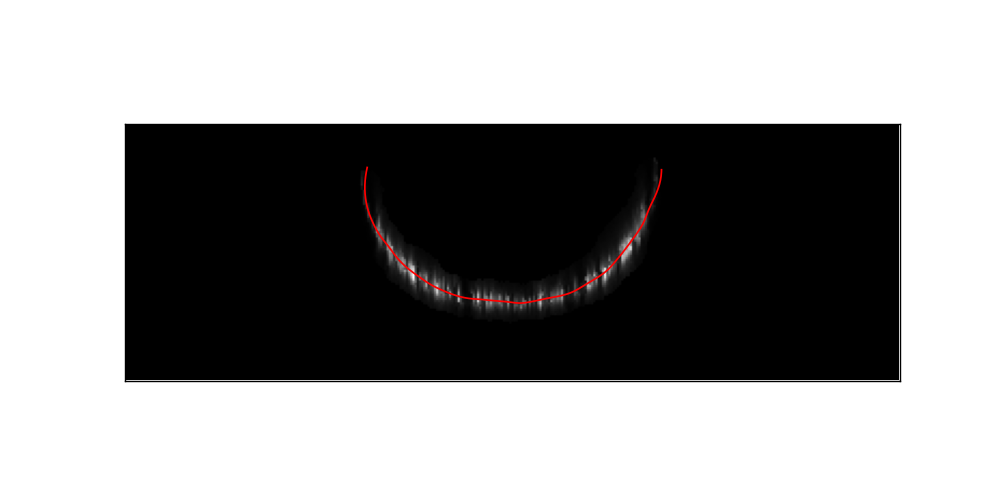

In [8]:
from scipy.signal import find_peaks
from scipy.ndimage import convolve1d

def moving_average(x, n = 3):
    """
    Apply a moving average operation of size n on the array x. 
    The size of the sliding window is reduced at the boundaries of x down to 1.
    The final array has the same shape of x.
    
    Parameters
    ----------
    x : numpy array
    n : integer
        
    Returns
    -------
    averaged: numpy array
        averaged numpy array

    """
    convolved = convolve1d(x, np.ones(n), mode='constant')
    normalization = convolve1d(np.ones(len(x)), np.ones(n), mode = 'constant')
    averaged = convolved/normalization
    return averaged

def fit_spline_onto_convex_profile(image, ref_mask, y_min_cutoff = 20, smoothing_n = 7):
    """
    This function takes an image containing a bright convex curve and a binary mask representing
    prior information about the curve. The function calculates a spline interpolation that follows the
    bright profile in the image and returns two arrays containing the x and y coordinates of 
    a set of uniformly distanced points along the spline.
    
    Parameters
    ----------
    image : 2-dim numpy array
    ref_mask  : 2-dim numpy array
    y_min_cutoff: int, optional
        cutoff position of the curve in the image in the y direction.
        The default is 20.
    smoothing_n: int, optional
        Size of the moving average window applied to the curve.
        The default is 7.
        
    Returns
    -------
    x_new, y_new: numpy arrays
        x and y coordinates of a set of uniformly distributed points along the spline curve.

    """
    
    ref_dist    = ndimage.distance_transform_cdt(ref_mask)
    image_dist   = ndimage.distance_transform_cdt(image > 0)
    smooth_image = gaussian(image, 2, preserve_range=False)
    
    # find starting points of the curve using the reference mask:
    peaks = []
    y_min = 0
    while (len(peaks) < 2) & (y_min < image.shape[0]):
        
        peaks, _ = find_peaks(ref_dist[y_min,:], distance = 10)
        y_min    = y_min+1
    
    if len(peaks) > 1:
        start_x1 = peaks[0]
        start_x2 = peaks[-1]
    
    else:
        return None
    
    # use the maxima along y for each position x, as starting points
    # for the spline fitting:
    x_o = np.linspace(start_x1, start_x2, np.abs(start_x1-start_x2), dtype = int)
    y_o = np.argmax(smooth_image[:,x_o], axis = 0)
    y_o[y_o < y_min] = y_min

    # reposition first and last point independently from where the brightness peaks are
    y_o[0]  = y_min
    y_o[-1] = y_min

    # add an extra point on both ends:
    if y_min_cutoff < y_min:
        
        y_o = np.insert(y_o, 0, y_min_cutoff)
        y_o = np.append(y_o, y_min_cutoff)

        x_o = np.insert(x_o, 0, x_o[0])
        x_o = np.append(x_o, x_o[-1])

    x_i = moving_average(x_o, n = smoothing_n)
    y_i = moving_average(y_o, n = smoothing_n)

    y_i[0]  = y_min_cutoff
    y_i[-1] = y_min_cutoff


    # resample the points to make the sampling more uniform and
    # create the array containing the distance of each point
    # from the first one along the curve.

    distances = [0]
    x = [x_i[0]]
    y = [y_i[0]]
    previous = 0
    dist_from_previous = 0
    minimum_dist = 6

    for i in range(1, len(x_i)):
        dist_from_previous += ((x_i[i]-x_i[i-1])**2 + (y_i[i]-y_i[i-1])**2)**0.5
        if dist_from_previous > minimum_dist:
            distances.append(distances[-1]+dist_from_previous)
            x.append(x_i[i])
            y.append(y_i[i])
            dist_from_previous = 0
            
    distances = np.array(distances)
    spline = make_interp_spline(distances, np.c_[x, y], k=2)
    x_new, y_new = spline(np.arange(0,int(max(distances)),1)).T
    
    return x_new, y_new

#######################################################################################
layer = 114
img_slice = (image_dsred)[:,:,layer]
ref_shape_slice = ref_shape[:,:,layer]
ref_mask_slice = ndimage.distance_transform_cdt(ref_shape_slice>0)

x_new, y_new = fit_spline_onto_convex_profile(img_slice, ref_mask_slice, y_min_cutoff = 20, smoothing_n = 10)

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(img_slice, cmap=plt.cm.gray)
ax.plot(x_new, y_new, "-r", lw=1)

ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_slice.shape[1], img_slice.shape[0], 0])

plt.show()

## Test spline projection

The spline projection transforms the 3D image stack (x,y,z with x is axis on which the stack is sliced), into 2D image in x-d coordinate where d is the distance along the spline. Splines from different slices are aligned using as a reference the center of the original image stack.

<IPython.core.display.Javascript object>


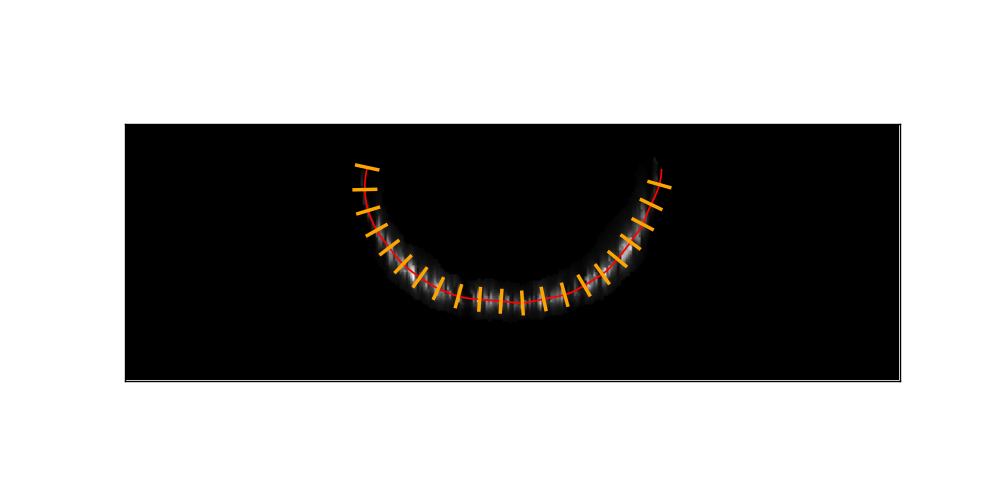

In [9]:
### Visualize the maximum projection along the spline:

#######################################################################################

img_slice = (image_dsred)[:,:,layer]
ref_mask_slice = ndimage.distance_transform_cdt(ref_shape_slice>0)

x, y = fit_spline_onto_convex_profile(img_slice, ref_mask_slice, y_min_cutoff = 20, smoothing_n = 10)

diff_x_fw = x[1:]-x[:-1]
diff_y_fw = y[1:]-y[:-1]
    
diff_x = np.concatenate([[0], diff_x_fw])+np.concatenate([diff_x_fw,[0]])
diff_y = np.concatenate([[0], diff_y_fw])+np.concatenate([diff_y_fw,[0]])
    
diff_x[1:-1] = diff_x[1:-1]/2 
diff_y[1:-1] = diff_y[1:-1]/2 

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(img_slice, cmap=plt.cm.gray)
ax.plot(x, y, "-r", lw=1)

radius = 5
for i in range(len(x)):
        
    norm = (diff_x[i]**2+diff_y[i]**2)**0.5
    perp_dx = -diff_y[i]/norm
    perp_dy = diff_x[i]/norm
    line_x = [x[i]-perp_dx*radius, x[i]+perp_dx*radius]
    line_y = [y[i]-perp_dy*radius, y[i]+perp_dy*radius]
    if i%10 == 0:
        ax.plot(line_x, line_y, "-", lw = 2, color = "orange")

ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_slice.shape[1], img_slice.shape[0], 0])

plt.show()

<IPython.core.display.Javascript object>


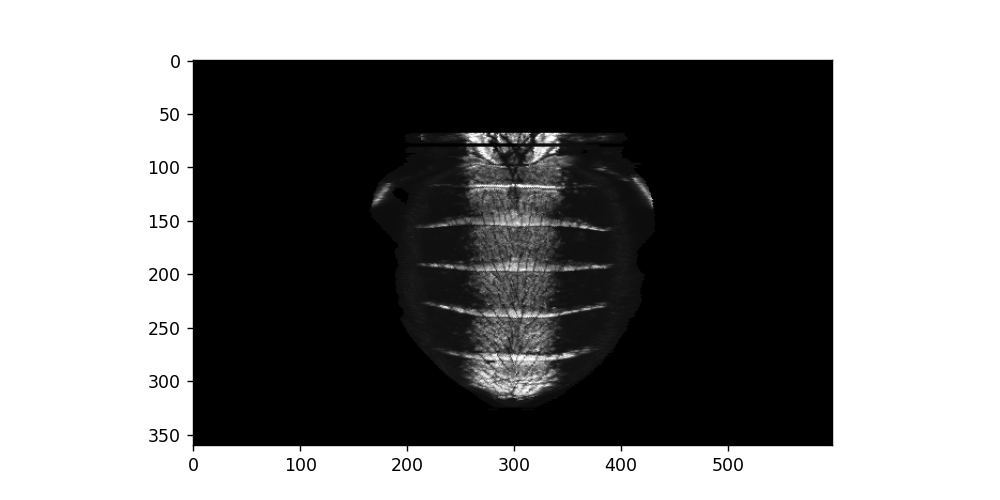

<IPython.core.display.Javascript object>


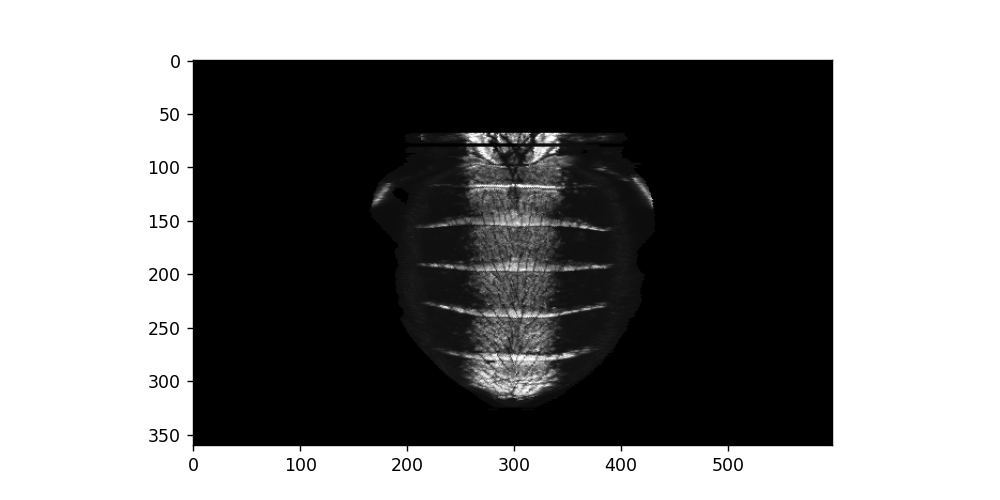

In [5]:
def brightness_along_curve_average(image, x, y, radius = 1):
    """
    This function returns the average brightness of an image in areas centered at a set of points.
    It can be used to obtain a brightness profile along an arbitrary curve.
    
    Parameters
    ----------
    image : 2-dim numpy array
    x : 1-dim numpy array
    y : 1-dim numpy array
    radius : integer, optional
        Distance around each point used for averaging the image brightness.
        The defaults is 1.
        
    Returns
    -------
    profile: numpy array
        average brightness around the given points.
    """
    profile = []

    for i in range(len(x)):
        r = int(y[i])
        c = int(x[i])
        profile.append(np.mean(image[(r-radius):(r+radius),(c-radius):(c+radius)]))
    
    return np.array(profile)


def brightness_along_curve_perp_max_min(image, x, y, radius = 1):
    """
    This function returns the maximum or minimum brightness of an image along an arbitrary curve
    defined by two arrays of x and y coordinates. The brightness value at each position x, y
    is calculated as the maximum along the local perpendicular direction to the curve, within a maximum 
    distance from the curve defined by the radius parameter.
    
    Parameters
    ----------
    image : 2-dim numpy array
    x : 1-dim numpy array
    y : 1-dim numpy array
    radius : integer, optional
        Maximum distance from each point to be considered when calculating the maximum brightness.
        The defaults is 1.
        
    Returns
    -------
    profile: numpy array
        maximum projected brightness along the curve.
    """

    profile = []
    
    diff_x_fw = x[1:]-x[:-1]
    diff_y_fw = y[1:]-y[:-1]
    
    diff_x = np.concatenate([[0], diff_x_fw])+np.concatenate([diff_x_fw,[0]])
    diff_y = np.concatenate([[0], diff_y_fw])+np.concatenate([diff_y_fw,[0]])
    
    diff_x[1:-1] = diff_x[1:-1]/2 
    diff_y[1:-1] = diff_y[1:-1]/2 
    
    for i in range(len(x)):
        
        norm = (diff_x[i]**2+diff_y[i]**2)**0.5
        perp_dx = -diff_y[i]/norm
        perp_dy = diff_x[i]/norm
        
        cols = []
        rows = []
        for j in range(-radius, radius+1):
            cols.append( round(x[i]+perp_dx*j) )
            rows.append( round(y[i]+perp_dy*j) )
        profile.append(np.max(image[rows, cols]))
            
    return profile 


def fly_abdomen_spline_projection(image_stack_ref, image_stack_signal, image_stack_mask, meridian_plane_x = 180, min_y = 0):
    """
    This function performs the 2d projection of a 3d image stack of a fly abdomen 
    with two fluorescent channels. The first channel is the reference channel and
    is used to define the abdomen surface. The second channel is the signal of interest.
    To calculate the 2d projection the abdomen is analyzed in slices along its axis.
    For each slice the profile of the abdomen is interpolated with a spline curve 
    and the image brightness is read out along the curve, taking the local maxima along
    the perpendicular. The 1 d brightness profile obtained from each image slice forms
    one row of the 2d projected image.
    
    Parameters
    ----------
    image_stack_ref : 2-dim numpy array
    image_stack_signal : 2-dim numpy array
    image_stack_mask : 2-dim numpy array
    min_y : integer, optional
        Minimium distance of the abdomen from the beginning of the image stack
        The defaults is 0.
    center_x : integer, optional
        center of the abomen in the x direction. used to align the profiles obtained from different slices.
        The defaults is 180.
        
    Returns
    -------
    projected: 2-dim numpy array
        The 2d projected image.
    """  

    
    stack_shape = image_stack_ref.shape
    projected = np.zeros([stack_shape[2], stack_shape[1]+2*stack_shape[0]])
    
    for layer in range(stack_shape[2]):
        image_slice  = image_stack_ref[:,:,layer]
        mask_slice   = image_stack_mask[:,:,layer]
        profile = fit_spline_onto_convex_profile(image_slice, mask_slice, min_y, smoothing_n = 10)

        if profile is not None:
            profile_x, profile_y = profile
        else:
            continue
        
        projected_section = brightness_along_curve_perp_max_min(image_stack_signal[:,:, layer], profile_x, profile_y, radius = 8)

        # find center:
        profile_center = np.argmin(np.absolute(profile_x-meridian_plane_x))
        projection_min = round(projected.shape[1]/2)-profile_center
        projection_max = projection_min+len(projected_section)
        projected[-layer, projection_min:projection_max] = projected_section
        
    return projected

from tifffile import imsave

gfp_filename = "../../data/03_registered/Registered_C1-D3_en_pnr_male_02_20221025.tif"
dsred_filename = "../../data/03_registered/Registered_C2-D3_en_pnr_male_02_20221025.tif"
abdomen_mask_file = "../../data/References_and_masks/Reference_abdomen_mask_iso_thick.tif"
abdomen_shape_reference_file = "../../data/References_and_masks/Reference_abdomen_mask_iso.tif"

image_gfp = io.imread(gfp_filename)
image_dsred = io.imread(dsred_filename)
image_mask = io.imread(abdomen_mask_file)
ref_shape = io.imread(abdomen_shape_reference_file)

image_gfp = image_gfp*image_mask
image_dsred = image_dsred*image_mask
projected_gfp = fly_abdomen_spline_projection(image_dsred, image_gfp, ref_shape)
projected_dsred = fly_abdomen_spline_projection(image_dsred, image_gfp, ref_shape)

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(projected_gfp, cmap=plt.cm.gray)
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(projected_dsred, cmap=plt.cm.gray)
plt.show()